### Supervised learning models
# Random forest

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve, auc)
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Random seed for reproducability
np.random.seed(42)

In [3]:
# Load data

train_data = pd.read_csv('framingham_train_processed.csv')
test_data = pd.read_csv('framingham_test_processed.csv')

X_train = train_data.drop('TenYearCHD', axis=1)
y_train = train_data['TenYearCHD']

X_test = test_data.drop('TenYearCHD', axis=1)
y_test = test_data['TenYearCHD']

print(f"Training data: {X_train.shape}")
print(f"Test data: {X_test.shape}")

Training data: (3390, 15)
Test data: (848, 15)


In [4]:
"""
Random forest hyperparamaters 

1. n_estimators: Number of trees
    - How many decision trees should we build
    - We'll test 50, 100, 200

2. max_depth: Maximun tree depth
    - How deep each tree can grow
    - Lower - simpler trees, may underfit
    - Higher - more complex trees, may overfit
    - We'll test 5, 10, 15, None

3. min_samples_leaf: Minimum sample per leaf
    - Minimum amount of samples per leaf
    - Lower - smaller leaves, may overfit
    - Higher - lagrger leaves, prevents overfitting
    - We'll test 1, 2, 4

4. class_weight; Handle class imbalance
    - 'balanced': Automatically weights rare cases more
    - None: Treats both cases equally
    - We'll test 'balanced', None 

"""

"\nRandom forest hyperparamaters \n\n1. n_estimators: Number of trees\n    - How many decision trees should we build\n    - We'll test 50, 100, 200\n\n2. max_depth: Maximun tree depth\n    - How deep each tree can grow\n    - Lower - simpler trees, may underfit\n    - Higher - more complex trees, may overfit\n    - We'll test 5, 10, 15, None\n\n3. min_samples_leaf: Minimum sample per leaf\n    - Minimum amount of samples per leaf\n    - Lower - smaller leaves, may overfit\n    - Higher - lagrger leaves, prevents overfitting\n    - We'll test 1, 2, 4\n\n4. class_weight; Handle class imbalance\n    - 'balanced': Automatically weights rare cases more\n    - None: Treats both cases equally\n    - We'll test 'balanced', None \n\n"

In [5]:
# Setting up cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [6]:
# Define hyperparameters grid

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

print("Hyperparameter combinations to test:")
print(f"  n_estimators: {param_grid_rf['n_estimators']}")
print(f"  max_depth: {param_grid_rf['max_depth']}")
print(f"  min_samples_leaf: {param_grid_rf['min_samples_leaf']}")
print(f"  class_weight: {param_grid_rf['class_weight']}")
print()

num_combinations = (len(param_grid_rf['n_estimators']) * 
                   len(param_grid_rf['max_depth']) * 
                   len(param_grid_rf['min_samples_leaf']) * 
                   len(param_grid_rf['class_weight']))

print(f"Total combinations: {num_combinations}")
print(f"With 5-fold CV: {num_combinations * 5} model trainings")

Hyperparameter combinations to test:
  n_estimators: [50, 100, 200]
  max_depth: [5, 10, 15, None]
  min_samples_leaf: [1, 2, 4]
  class_weight: ['balanced', None]

Total combinations: 72
With 5-fold CV: 360 model trainings


In [7]:
# Create base model
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

In [8]:
# Running grid search 

grid_search_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    cv=cv,
    scoring='roc_auc',  # Optimize for ROC-AUC
    n_jobs=-1,  # Use all CPU cores
    verbose=1  # Print progress
)

# Fit the grid search
print("Starting Grid Search")
grid_search_rf.fit(X_train, y_train)

print()
print("Grid Search Complete!")
print()

Starting Grid Search
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Grid Search Complete!



In [9]:
# Best hyperparameters found

print(f"Best parameters: {grid_search_rf.best_params_}")
print(f"Best cross-validation ROC-AUC score: {grid_search_rf.best_score_:.4f}")
print()

# Get the best model
rf_model = grid_search_rf.best_estimator_

Best parameters: {'class_weight': None, 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 200}
Best cross-validation ROC-AUC score: 0.7232



In [10]:
# Top 10 Hyperparamter combinations

results_df = pd.DataFrame(grid_search_rf.cv_results_)
results_df = results_df[['param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 
                          'param_class_weight', 'mean_test_score', 'std_test_score']]
results_df.columns = ['n_estimators', 'max_depth', 'min_samples_leaf', 'class_weight', 
                      'Mean ROC-AUC', 'Std ROC-AUC']
results_df = results_df.sort_values('Mean ROC-AUC', ascending=False)

print(results_df.head(10))
print()


    n_estimators max_depth  min_samples_leaf class_weight  Mean ROC-AUC  \
38           200         5                 1         None      0.723161   
41           200         5                 2         None      0.722837   
44           200         5                 4         None      0.721790   
8            200         5                 4     balanced      0.720260   
5            200         5                 2     balanced      0.720091   
39            50         5                 2         None      0.719458   
40           100         5                 2         None      0.719257   
2            200         5                 1     balanced      0.718994   
42            50         5                 4         None      0.718360   
6             50         5                 4     balanced      0.718220   

    Std ROC-AUC  
38     0.024839  
41     0.024556  
44     0.024747  
8      0.021152  
5      0.021264  
39     0.021395  
40     0.023841  
2      0.020689  
42     0.022

In [11]:
# Saving the model
import pickle

with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

print("Model saved as 'rf_model.pkl'")
print()

Model saved as 'rf_model.pkl'



## Evaluating the model

In [12]:
# Define metrics for evaluation
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



In [13]:
# Perform cross-validation with all metrics
cv_results = cross_validate(
    rf_model, 
    X_train, 
    y_train, 
    cv=cv, 
    scoring=scoring,
    return_train_score=True
)

In [14]:
for metric in scoring.keys():
    train_scores = cv_results[f'train_{metric}']
    test_scores = cv_results[f'test_{metric}']
    
    print(f"{metric.upper()}:")
    print(f"  Training:  {train_scores.mean():.4f} (±{train_scores.std():.4f})")
    print(f"  CV Test:   {test_scores.mean():.4f} (±{test_scores.std():.4f})")
    print(f"  Individual folds: {[f'{score:.4f}' for score in test_scores]}")
    print()

ACCURACY:
  Training:  0.8560 (±0.0012)
  CV Test:   0.8490 (±0.0018)
  Individual folds: ['0.8510', '0.8466', '0.8481', '0.8481', '0.8510']

PRECISION:
  Training:  1.0000 (±0.0000)
  CV Test:   0.5800 (±0.3816)
  Individual folds: ['1.0000', '0.4000', '0.0000', '0.5000', '1.0000']

RECALL:
  Training:  0.0524 (±0.0078)
  CV Test:   0.0136 (±0.0078)
  Individual folds: ['0.0194', '0.0194', '0.0000', '0.0097', '0.0194']

F1:
  Training:  0.0995 (±0.0140)
  CV Test:   0.0265 (±0.0151)
  Individual folds: ['0.0381', '0.0370', '0.0000', '0.0190', '0.0381']

ROC_AUC:
  Training:  0.8069 (±0.0051)
  CV Test:   0.7232 (±0.0248)
  Individual folds: ['0.7407', '0.7033', '0.7152', '0.7619', '0.6946']



In [15]:
# Make predictions on test set
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability of class 1


test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")
print(f"ROC-AUC:   {test_roc_auc:.4f}")

Accuracy:  0.8467
Precision: 0.3333
Recall:    0.0078
F1-Score:  0.0152
ROC-AUC:   0.6852


In [16]:
# Confutsion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print()

tn, fp, fn, tp = cm.ravel()

print("Interpretation:")
print(f"  True Negatives (TN):  {tn}")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")
print(f"  True Positives (TP):  {tp}")
print()

[[717   2]
 [128   1]]

Interpretation:
  True Negatives (TN):  717
  False Positives (FP): 2
  False Negatives (FN): 128
  True Positives (TP):  1



In [17]:
# Detailed classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       719
           1       0.33      0.01      0.02       129

    accuracy                           0.85       848
   macro avg       0.59      0.50      0.47       848
weighted avg       0.77      0.85      0.78       848



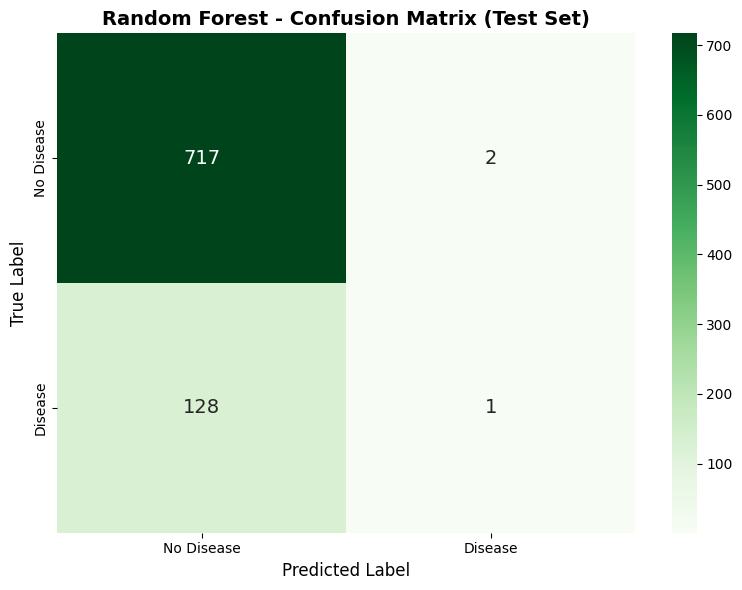

In [18]:
# Confusion matrix display
fig, ax = plt.subplots(figsize=(8, 6))

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'],
            cbar=True, ax=ax, annot_kws={'size': 14})

ax.set_title('Random Forest - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

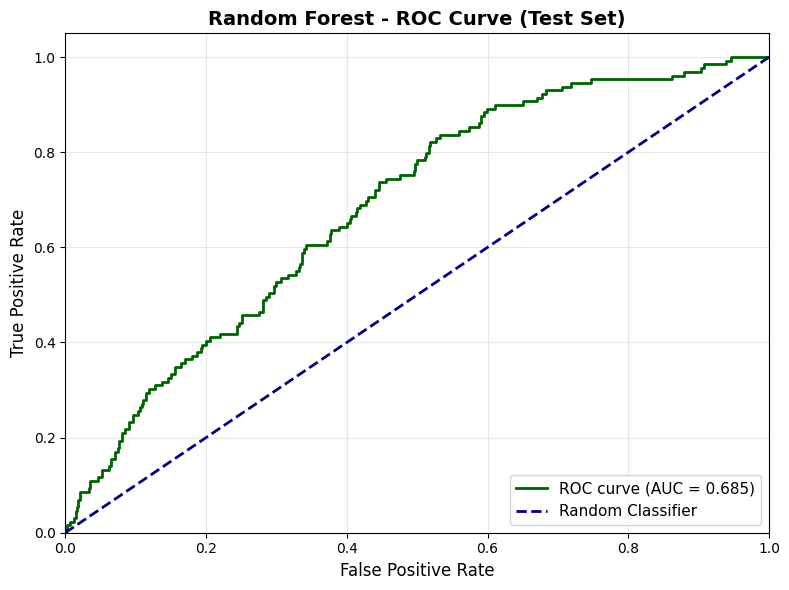

In [19]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Random Forest - ROC Curve (Test Set)', fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

            Feature  Importance
0               age    0.223495
3             sysBP    0.175290
4             diaBP    0.114822
7           glucose    0.098596
5               BMI    0.066738
12     prevalentHyp    0.066191
2           totChol    0.063303
1        cigsPerDay    0.052893
6         heartRate    0.040830
8              male    0.024764
14        education    0.020876
13         diabetes    0.017531
10           BPMeds    0.014066
11  prevalentStroke    0.011987
9     currentSmoker    0.008618



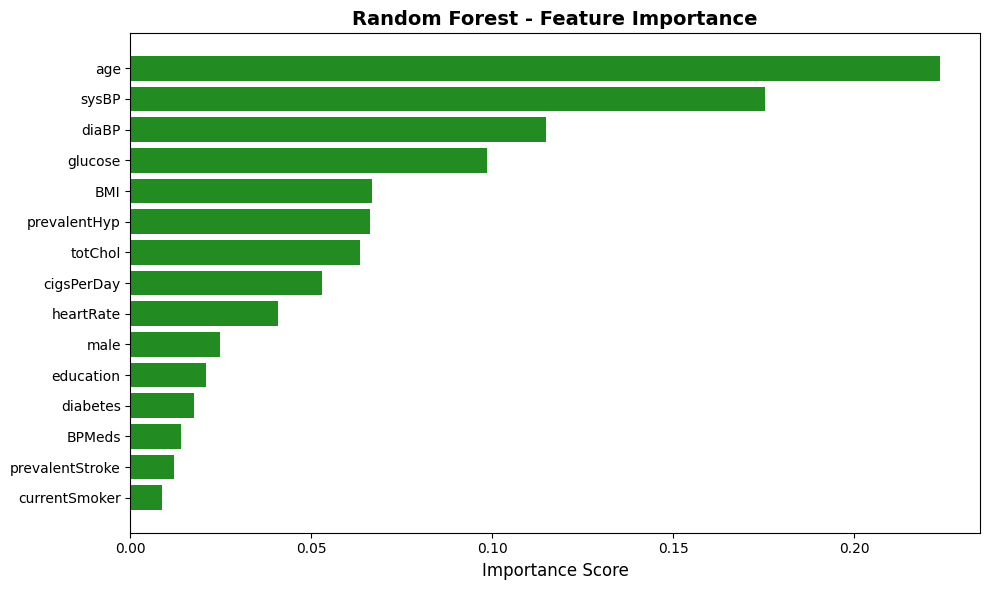

In [20]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance)
print()

# Visualize top features
fig, ax = plt.subplots(figsize=(10, 6))


ax.barh(range(len(feature_importance)), feature_importance['Importance'].values, color='forestgreen')
ax.set_yticks(range(len(feature_importance)))
ax.set_yticklabels(feature_importance['Feature'].values)
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Random Forest - Feature Importance', fontsize=14, fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

In [21]:
rf_results = {
    'model_name': 'Random Forest',
    'test_metrics': {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'roc_auc': test_roc_auc
    },
    'cv_metrics': {
        'accuracy': (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()),
        'precision': (cv_results['test_precision'].mean(), cv_results['test_precision'].std()),
        'recall': (cv_results['test_recall'].mean(), cv_results['test_recall'].std()),
        'f1': (cv_results['test_f1'].mean(), cv_results['test_f1'].std()),
        'roc_auc': (cv_results['test_roc_auc'].mean(), cv_results['test_roc_auc'].std())
    }
}

with open('rf_results.pkl', 'wb') as f:
    pickle.dump(rf_results, f)

In [22]:
print("KEY FINDINGS:")
print()
print(f"  - CV Recall: {cv_results['test_recall'].mean():.1%}")
print(f"    (Catches {cv_results['test_recall'].mean():.1%} of disease cases)")
print()
print(f"  - Test ROC-AUC: {test_roc_auc:.4f}")
print(f"    (Ability to distinguish classes)")
print()
print(f"  - Most important features: {', '.join(feature_importance.head(3)['Feature'].values)}")
print()

KEY FINDINGS:

  - CV Recall: 1.4%
    (Catches 1.4% of disease cases)

  - Test ROC-AUC: 0.6852
    (Ability to distinguish classes)

  - Most important features: age, sysBP, diaBP

